In [1]:
import numpy as np
import matplotlib.pyplot as plt
import odc.geo.xr
from datacube.utils.cog import write_cog
import netCDF4
import h5py
import geopandas as gpd
import xarray as xr
import rasterio
import odc.geo.geobox
import argparse
from pathlib import Path
import glob
import sys
import os
import pandas as pd
import pdb
from dea_tools.spatial import xr_vectorize, xr_rasterize
from tqdm.auto import tqdm

ModuleNotFoundError: No module named 'odc'

In [3]:
path = '/g/data/gv90/P6_data/Bremen/MYI/'

file_list = []

# create list of paths
print("Finding files")
for year in [2018]:
    for file in Path(path).rglob(f'ECICE*.nc'):
        file_list.append(file)

Finding files


In [4]:
def paths_to_datetimeindex(paths, string_slice=(0, 10), form='%Y%m'):
    """
    Helper function to generate a Pandas datetimeindex object
    from dates contained in a file path string.
    Parameters
    ----------
    paths : list of strings
        A list of file path strings that will be used to extract times
    string_slice : tuple
        An optional tuple giving the start and stop position that
        contains the time information in the provided paths. These are
        applied to the basename (i.e. file name) in each path, not the
        path itself. Defaults to (0, 10).
    Returns
    -------
    A pandas.DatetimeIndex object containing a 'datetime64[ns]' derived
    from the file paths provided by `paths`.
    """
    date_strings = [os.path.basename(i)[slice(*string_slice)]
                    for i in paths]
    return pd.to_datetime(date_strings, format=form)


# parser = argparse.ArgumentParser(description="Arguments",
#                                  formatter_class=argparse.ArgumentDefaultsHelpFormatter)
# parser.add_argument("--src", help="Source location")
# parser.add_argument("--dest", help="Destination location")
# args = vars(parser.parse_args())


In [5]:
# Create list of ECICE data
# Daily and 12.5 km grid
file_list = sorted(file_list, key=lambda i: int(os.path.splitext(os.path.basename(i)[26:34])[0]))#[0:365]
print(f"Processing {len(file_list)} files")

Processing 4102 files


In [6]:
# Create variable used for time axis
# %m = zero padded decimal for month
# % d = zero padded decimal for day
time_var = xr.Variable('time', paths_to_datetimeindex(file_list,
                                                      string_slice=(26,34), form='%Y%m%d'))

# Load in and concatenate individual data
# decode_coords all reads the polar_stereographic projection as a coordinate
ds = xr.concat([xr.open_dataset(i, chunks='auto') for i in tqdm(file_list)], data_vars = ['MYI','FYI','YI', 'TOTAL_ICE'],
                        dim=time_var, coords='minimal', compat='minimal')
ds = ds.odc.assign_crs('EPSG:3031')

  0%|          | 0/4102 [00:00<?, ?it/s]

In [7]:
ds

<xarray.Dataset>
Dimensions:      (time: 4102, X: 664, Y: 632)
Coordinates:
  * time         (time) datetime64[ns] 2013-02-01 2013-02-02 ... 2023-02-28
    spatial_ref  int32 3031
Dimensions without coordinates: X, Y
Data variables:
    YI           (time, X, Y) float64 dask.array<chunksize=(1, 664, 632), meta=np.ndarray>
    FYI          (time, X, Y) float64 dask.array<chunksize=(1, 664, 632), meta=np.ndarray>
    MYI          (time, X, Y) float64 dask.array<chunksize=(1, 664, 632), meta=np.ndarray>
    TOTAL_ICE    (time, X, Y) float64 dask.array<chunksize=(1, 664, 632), meta=np.ndarray>
Attributes:
    history:      ECICE wrapper: myi-processing <tag>-<commits-since>-g<commi...
    distversion:  AQ2
    Convention:   None
    title:        Multiyear ice concentration from active and passive microwa...
    institution:  University of Bremen
    references:   http://www.seaice.uni-bremen.de/multiyear-ice-concentration
    grid_info:    NSIDC polar stereographic 12.5km grid, Antarctic, \n    see...
    comment:      Projection information: NSIDC Sea Ice Polar Stereographic S...

In [7]:
monthly_mean = ds.resample(time="M").mean()

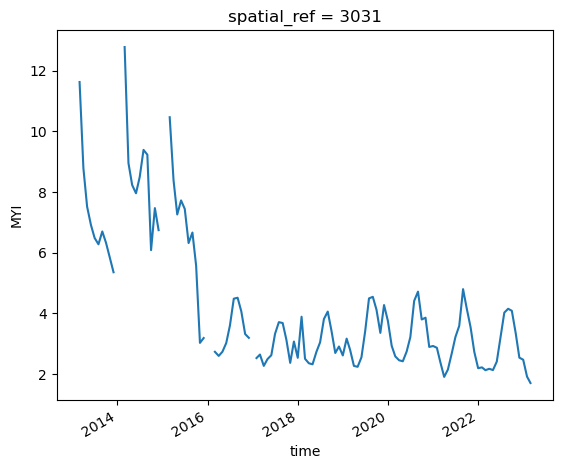

In [9]:
monthly_mean['MYI'].mean(dim=('X','Y')).plot()

In [11]:
ds.to_netcdf('/g/data/gv90/P6_data/processed/ECICE_ICETYPE_MONTHLY.nc')

IOStream.flush timed out

KeyboardInterrupt



In [10]:
area = xr.open_dataset('/g/data/jk72/sc0554/floes/contributors/smtc/NSIDC0771_CellArea_PS_S12.5km_v1.0.nc')
# area['cell_area'] = area['cell_area'].rename({'x':'Y','y':'X'})
area['cell_area'] = area['cell_area'] / (1000*1000)

In [2]:
latlon = xr.open_dataset('/g/data/jk72/sc0554/floes/contributors/smtc/NSIDC0771_LatLon_PS_S12.5km_v1.0.nc')


NameError: name 'xr' is not defined

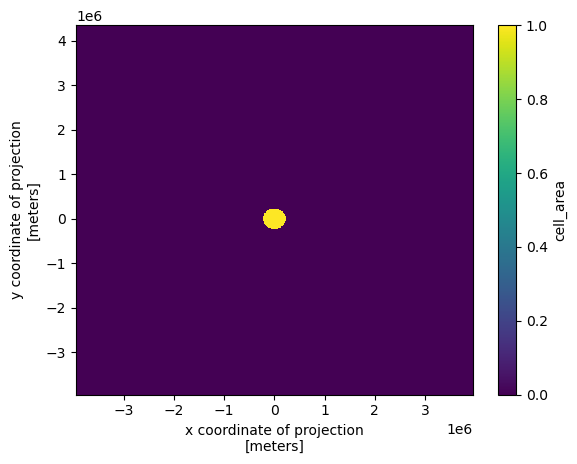

In [85]:
(area['cell_area'] > 166).plot()

In [14]:
MYI_area = monthly_mean['MYI'] * area['cell_area']

In [15]:
MYI_area

,Array,Chunk
Bytes,155.04 TiB,3.84 TiB
Shape,"(121, 664, 632, 664, 632)","(3, 664, 632, 664, 632)"
Count,27432 Tasks,114 Chunks
Type,float64,numpy.ndarray


In [ ]:
MYI_area.isel(time=8).plot()

In [ ]:
monthly_mean_df = MYI_area.sum(dim=('X','Y')).to_pandas()

In [ ]:
monthly_mean_df.to_frame().plot()